**Import Data**


In [2]:
# Obtain data from yfinance
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Define the list of top 100 company tickers, use only AAPL for now
tickers = ['AAPL']

# Set the date range
start_date = '1994-11-06'
end_date = datetime.today().strftime('%Y-%m-%d')

# Loop through each ticker and download data
for ticker in tickers:
    # Download historical data
    data = yf.download(ticker, start=start_date, end=end_date)
    # Reset column names to avoid mismatched headers
    data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    # Reset the index to a new "Date" column and keep only the date part
    data.reset_index(inplace=True)
    data['Date'] = data['Date'].dt.date  # Convert DateTime to just date (YYYY-MM-DD format) to get rid of hours, minutes, and seconds
    data['Date'] = pd.to_datetime(data['Date']) # Convert 'Date' column to datetime format so model interpre it as dates


    # Save to CSV with Date as a column
    data.to_csv(f'{ticker}_30yrs.csv', index=False)  # Save without the index to make Date a column
print('\n')
# print(data.tail())
print(data.head())



[*********************100%***********************]  1 of 1 completed



        Date  Adj Close     Close      High       Low      Open     Volume
0 1994-11-07   0.302541  0.363839  0.368304  0.358259  0.360491  113041600
1 1994-11-08   0.313678  0.377232  0.380580  0.359375  0.362723  348969600
2 1994-11-09   0.309038  0.371652  0.383929  0.366071  0.381696  406336000
3 1994-11-10   0.306718  0.368862  0.373884  0.366071  0.372768  152980800
4 1994-11-11   0.305326  0.367188  0.370536  0.366071  0.368304   62272000


**Build and `fit` ANN model**

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0012 - mae: 0.0129 - val_loss: 0.0015 - val_mae: 0.0313
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3547e-05 - mae: 0.0042 - val_loss: 0.0014 - val_mae: 0.0314
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5660e-05 - mae: 0.0041 - val_loss: 7.3796e-04 - val_mae: 0.0215
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6088e-05 - mae: 0.0033 - val_loss: 0.0011 - val_mae: 0.0275
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2261e-05 - mae: 0.0037 - val_loss: 5.7151e-04 - val_mae: 0.0188
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8013e-05 - mae: 0.0031 - val_loss: 0.0028 - val_mae: 0.0482
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4141e-05 - mae: 0.0034 - val_loss: 0.0072 - val_mae: 0.0786
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3924e-05 - mae: 0.0046 - val_loss: 6.0333e-04 - val_mae: 0.0196
Epoch 9/20
211/2

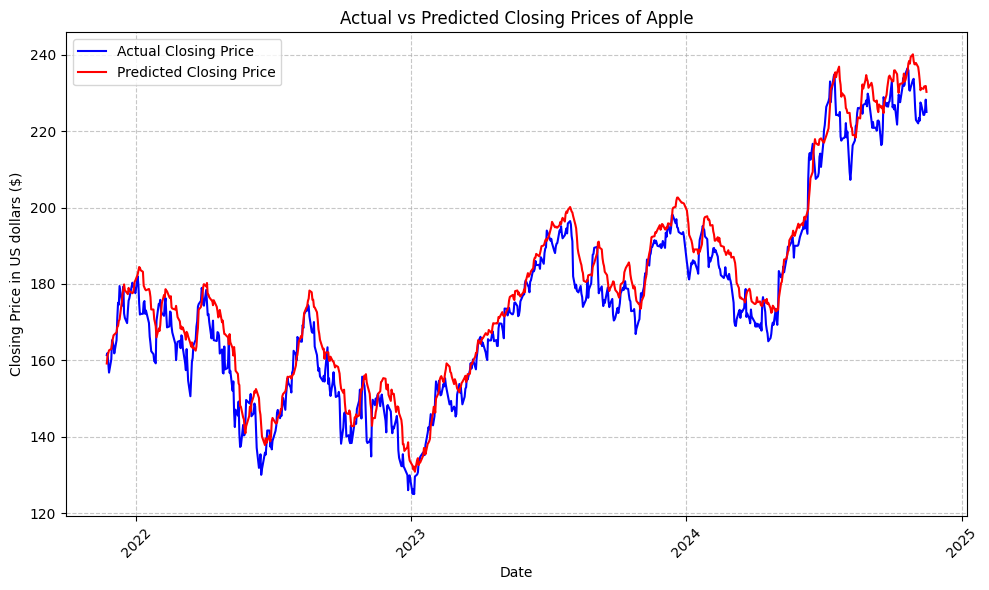

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load data
data = pd.read_csv('AAPL_30yrs.csv')
data['Date'] = pd.to_datetime(data['Date'])  # Convert 'Date' column to datetime

# Use only the 'Close' column for prediction
close_prices = data[['Close']]

# Normalize the close prices for better training performance
scaler = MinMaxScaler()
close_prices_scaled = scaler.fit_transform(close_prices)

# Define sequence length (e.g., 60 days of historical prices)
sequence_length = 60

# Create sequences and targets for the model
X = []
y = []
for i in range(sequence_length, len(close_prices_scaled)):
    X.append(close_prices_scaled[i-sequence_length:i])  # Last 60 days
    y.append(close_prices_scaled[i, 0])  # Next day's price

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape X to (samples, features) for Dense layers
X = X.reshape(X.shape[0], X.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Build the ANN model
model = Sequential([
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
epochs = 20
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

# Predict on test data
y_pred_scaled = model.predict(X_test)

# Reverse the normalization to get predictions in the original scale
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_unscaled = scaler.inverse_transform(y_pred_scaled).flatten()

# Plot the actual vs. predicted values on test data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(data['Date'][-len(y_test):], y_test_unscaled, label='Actual Closing Price', color='blue')
plt.plot(data['Date'][-len(y_test):], y_pred_unscaled, label='Predicted Closing Price', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price in US dollars ($)')
plt.title("Actual vs Predicted Closing Prices of Apple")
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
